In [1]:
import numpy as np
import sys
sys.path.append('../')
from src.Mondrian_matrix_utils import simulate, simulate_best
import pickle
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
import pandas as pd

def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = np.matmul(x, rotation)
    y = res[:, 0]**4# + res[:, 1]**4 + res[:, 2]**4 + res[:, 3]**4 + res[:, 4]**4
    r_noise = np.random.RandomState(seed)
    n = len(x)
    noise = r_noise.randn(n, 1) * np.sqrt(noise_sig2)
    y = y + noise[:, 0]
    return y

In [2]:
n = 10000
dim_in = 10
active = 1
#rotation = pickle.load(open("rotation.pk", "rb"))
rotation = special_ortho_group.rvs(dim_in)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [5000, 7500, 10000]

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta


In [3]:
import jax.numpy as jnp
from jax import grad, vmap

def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    first_five = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, first_five)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y

In [4]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)

In [5]:
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / 5000
true_H = true_H / two_one_norm(true_H)

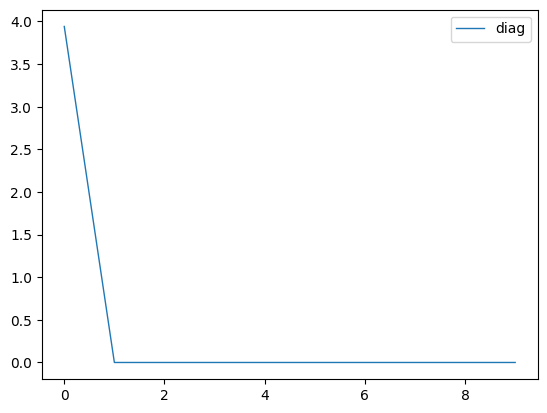

In [6]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [7]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    eigenvalues, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

number of training samples: 5000
Simulation: 0
Test mean squared error before transformation: 0.5609774347677443


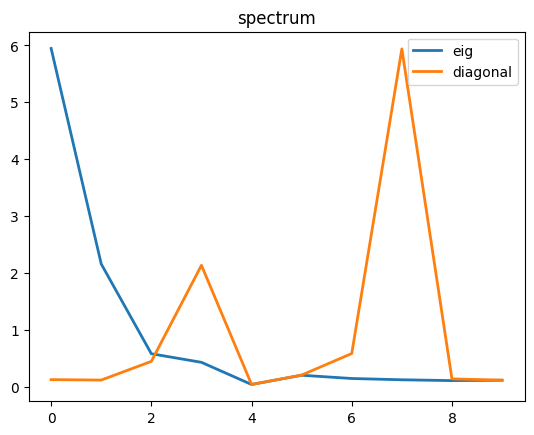

Test mean squared error after transformation: 0.5444289230656711
[0.77059656]
Simulation: 1
Test mean squared error before transformation: 0.5604822444570217


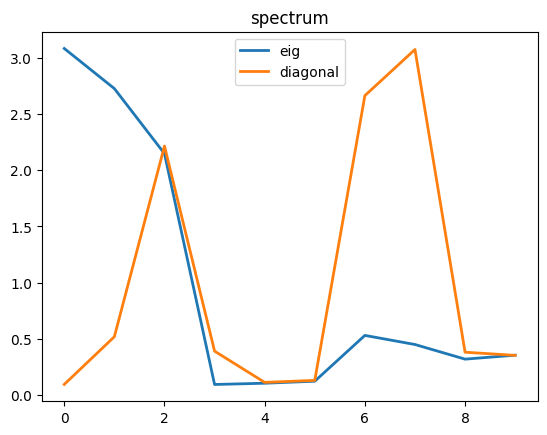

Test mean squared error after transformation: 0.5386155316029824
[0.84615837]
Simulation: 2
Test mean squared error before transformation: 0.5615150798060479


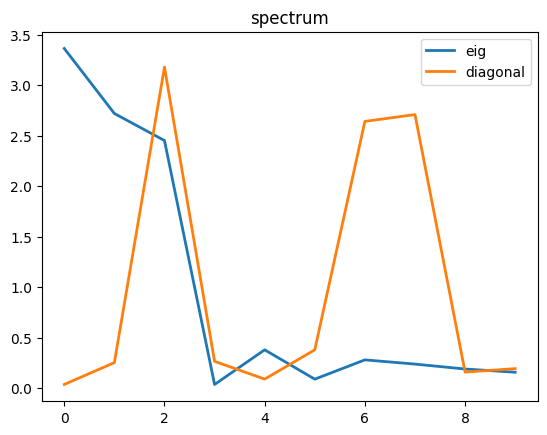

Test mean squared error after transformation: 0.5312534682658395
[0.80164153]
Simulation: 3
Test mean squared error before transformation: 0.5596033674706353


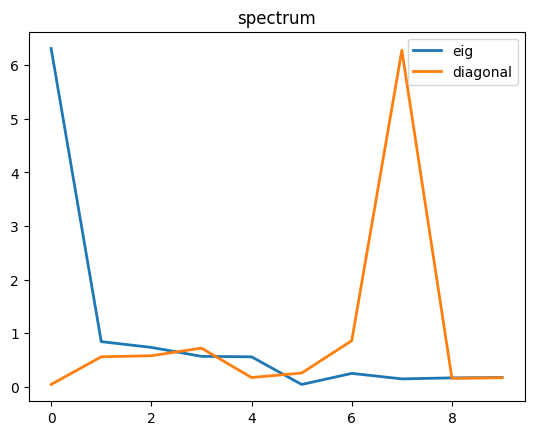

Test mean squared error after transformation: 0.5366807066995593
[0.7814062]
Simulation: 4
Test mean squared error before transformation: 0.5593890334050088


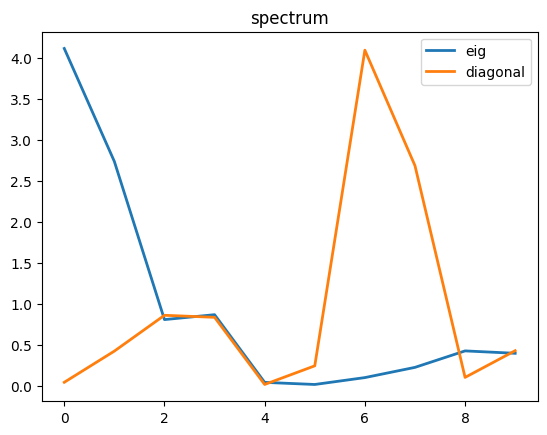

Test mean squared error after transformation: 0.5406683116140872
[1.29682152]
number of training samples: 7500
Simulation: 0
Test mean squared error before transformation: 0.5582386261310965


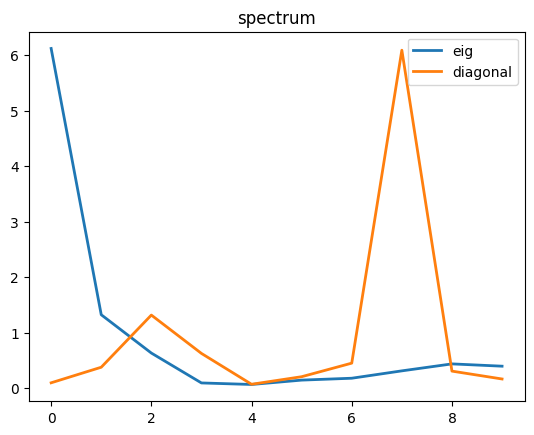

Test mean squared error after transformation: 0.536394282523968
[0.80844339]
Simulation: 1
Test mean squared error before transformation: 0.5597751858032365


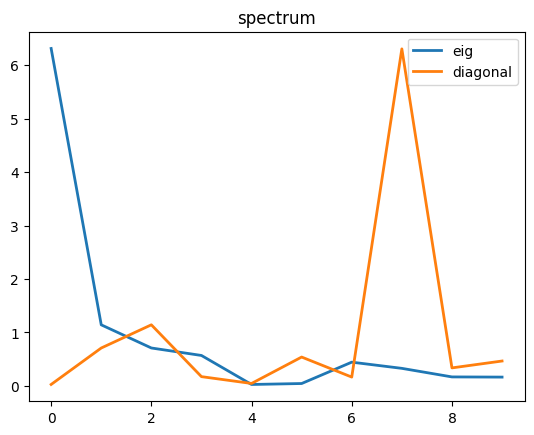

Test mean squared error after transformation: 0.530794605724431
[0.77289361]
Simulation: 2
Test mean squared error before transformation: 0.5558597271892964


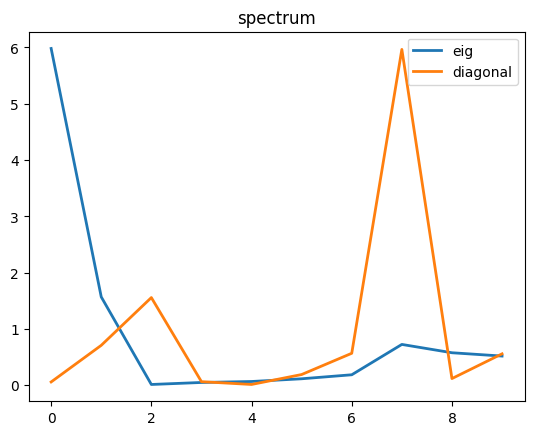

Test mean squared error after transformation: 0.5272770416735926
[0.73278362]
Simulation: 3
Test mean squared error before transformation: 0.5562033291938233


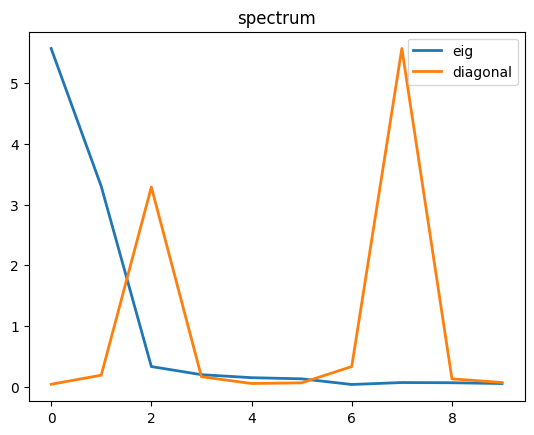

Test mean squared error after transformation: 0.5186730961114233
[0.78108037]
Simulation: 4
Test mean squared error before transformation: 0.5571126935412136


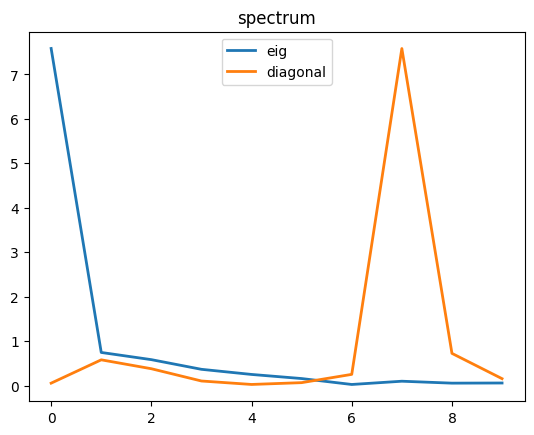

Test mean squared error after transformation: 0.5365092439096815
[0.78242922]
number of training samples: 10000
Simulation: 0
Test mean squared error before transformation: 0.5617835768815473


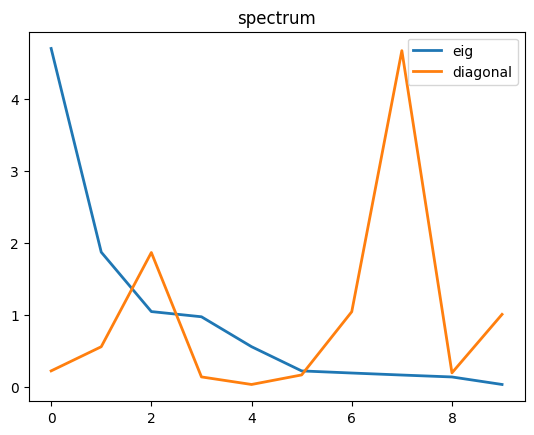

Test mean squared error after transformation: 0.5322291649111021
[0.80227502]
Simulation: 1
Test mean squared error before transformation: 0.5578707115010341


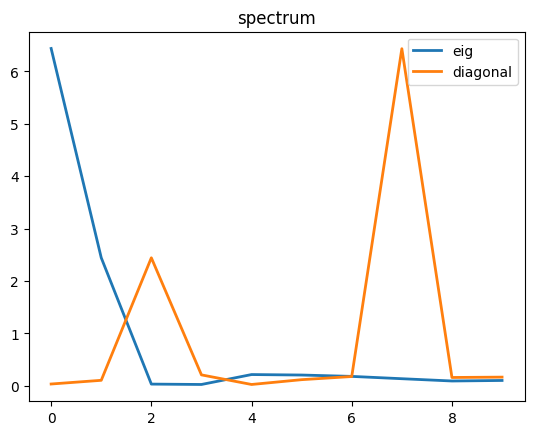

Test mean squared error after transformation: 0.5274014065162181
[0.77331431]
Simulation: 2
Test mean squared error before transformation: 0.5628950837737622


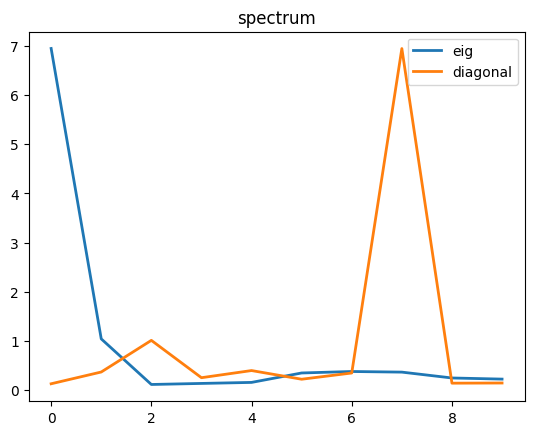

Test mean squared error after transformation: 0.53475271453564
[0.77428001]
Simulation: 3
Test mean squared error before transformation: 0.5584281617543476


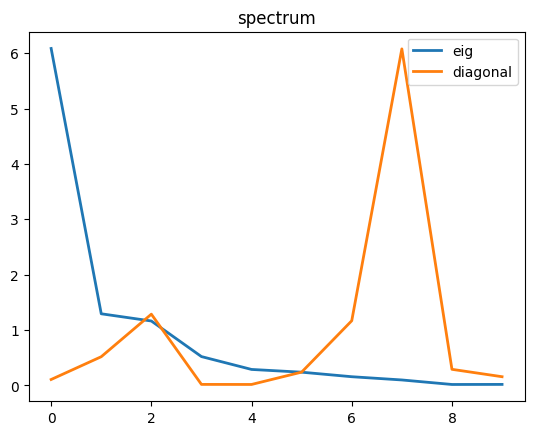

Test mean squared error after transformation: 0.5284263566171662
[0.78239971]
Simulation: 4
Test mean squared error before transformation: 0.5597087138886613


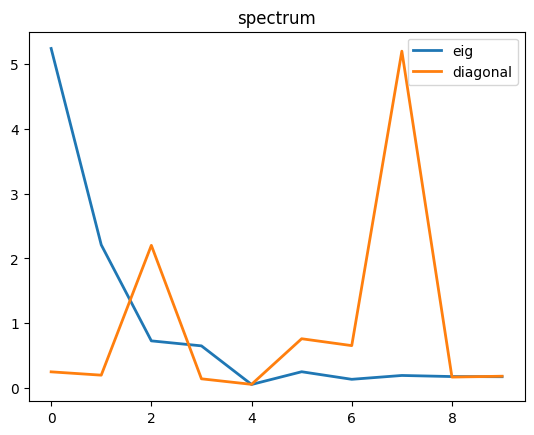

Test mean squared error after transformation: 0.5349317512403393
[0.81173403]


In [8]:
stats = []

for n_sim in sample_range:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'before': [], "after": []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_before, mse_after, H = simulate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta, weights_lifetime)
        print(get_angle_distance(H, true_H))
        mse['before'].append(mse_before)
        mse['after'].append(mse_after)
    stats.append(mse)

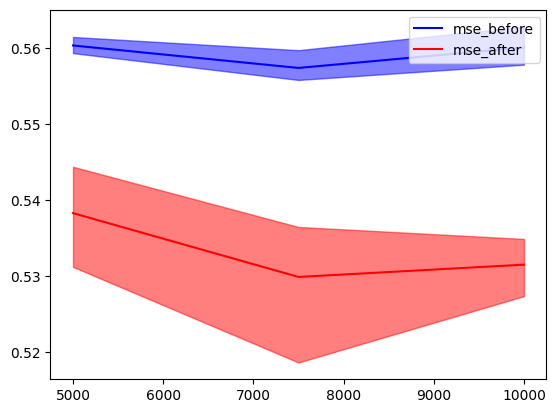

In [9]:
#stats = pickle.load(open("stat.pk", "rb"))
x = sample_range
before = []
before_min = []
before_max = []
after = []
after_min = []
after_max = []

for stat in stats:
    before.append(np.mean(stat['before']))
    before_min.append(np.min(stat['before']))
    before_max.append(np.max(stat['before']))
    after.append(np.mean(stat['after']))
    after_min.append(np.min(stat['after']))
    after_max.append(np.max(stat['after']))

fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.5)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.5)

plt.legend(["mse_before", "mse_after"], loc ="upper right")

In [14]:
from src.Mondrian_matrix_utils import *

stats_best = {}
best = {}

for multiplier in range(1,2):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_proj(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime, rotation=rotation)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))

lifetime multiplier: 1
number of training samples: 5000
Simulation: 0
0.5234990182069545
Simulation: 1
0.5208951980692929
Simulation: 2
0.5245291739899512
Simulation: 3
0.5264915112892268
Simulation: 4
0.515276561066038
number of training samples: 7500
Simulation: 0
0.5124435963851226
Simulation: 1
0.523589154697122
Simulation: 2
0.517371258105303
Simulation: 3
0.5124910424674124
Simulation: 4
0.5157102997145286
number of training samples: 10000
Simulation: 0
0.5193491000372672
Simulation: 1
0.5200770720670882
Simulation: 2
0.5145280517968156
Simulation: 3
0.519159485998994
Simulation: 4
0.5244675454609992


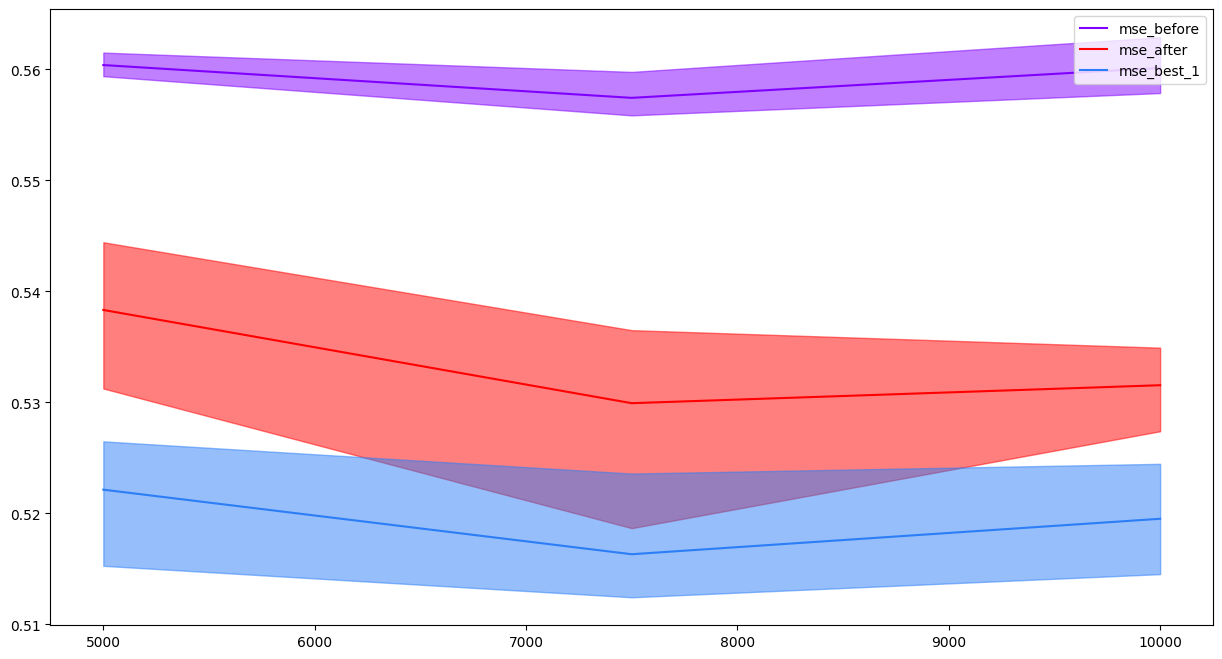

In [15]:
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, before, color=colors[0])
ax.plot(x, after, color=colors[6])
for multiplier in range(1,2):
    ax.plot(x, best[multiplier]["mean"], color=colors[multiplier])
plt.legend(["mse_before", "mse_after", "mse_best_1", "mse_best_2"], loc ="upper right")
ax.fill_between(x, (before_min), (before_max), color=colors[0], alpha=.5)
ax.fill_between(x, (after_min), (after_max), color=colors[6], alpha=.5)
for multiplier in range(1,2):
    ax.fill_between(x, (best[multiplier]["min"]), (best[multiplier]["max"]), color=colors[multiplier], alpha=.5)

In [16]:
from src.Mondrian_matrix_utils import *

def simulate_proj_H(x_train, y_train, x_test, y_test, M, lifetime_max, delta, weights_lifetime, H = None):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    _, _, history, w_kernel, _ = train(x_train_transformed, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    _, y_hat_test = evaluate(x_test_transformed, y_train, x_test_transformed, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_best = mean_squared_error(y_test, y_hat_test)

    return mse_best

stats_best = {}
best = {}

for multiplier in range(1,2):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime, H = true_H)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))


lifetime multiplier: 1
number of training samples: 5000
Simulation: 0
0.41130549969564945
Simulation: 1
0.40729704886876056
Simulation: 2
0.4190597788995341
Simulation: 3
0.4134502776961176
Simulation: 4
0.4050696403118298
number of training samples: 7500
Simulation: 0
0.4127628845645295
Simulation: 1
0.40834329463765195
Simulation: 2
0.4129579809495639
Simulation: 3
0.4099678911233399
Simulation: 4
0.4110446413529837
number of training samples: 10000
Simulation: 0
0.42199790725169006
Simulation: 1
0.4272817884453872
Simulation: 2
0.41633318088977994
Simulation: 3
0.41785469273855724
Simulation: 4
0.4202990143071222


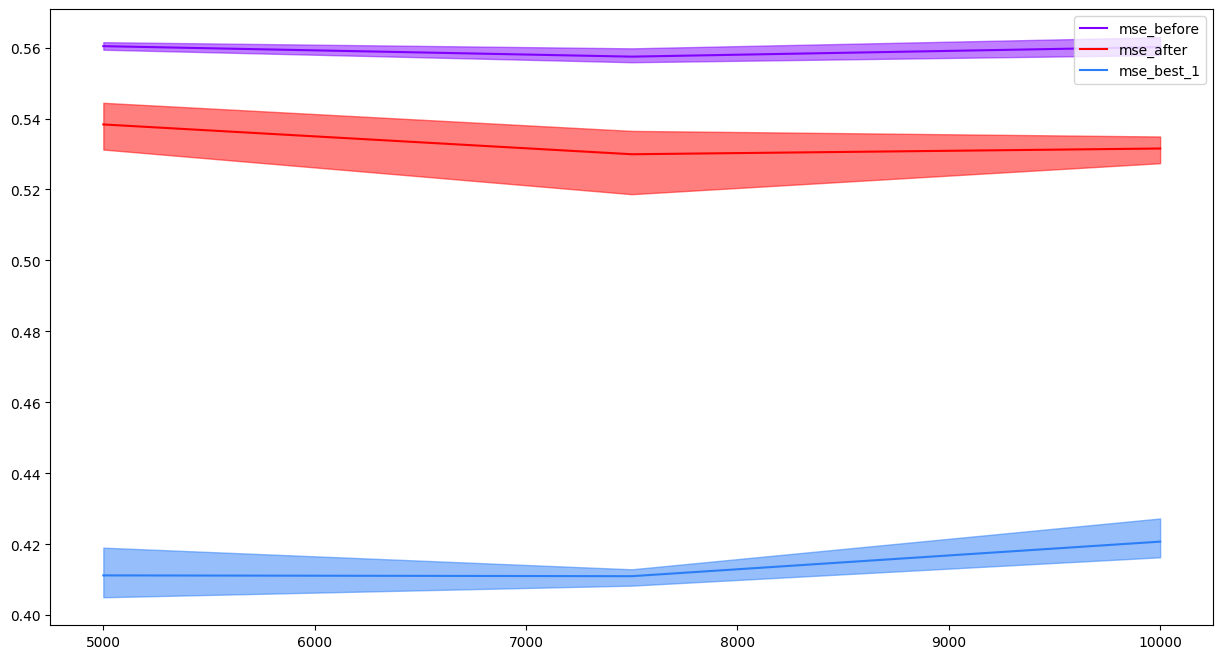

In [18]:
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, before, color=colors[0])
ax.plot(x, after, color=colors[6])
for multiplier in range(1,2):
    ax.plot(x, best[multiplier]["mean"], color=colors[multiplier])
plt.legend(["mse_before", "mse_after", "mse_best_1", "mse_best_2"], loc ="upper right")
ax.fill_between(x, (before_min), (before_max), color=colors[0], alpha=.5)
ax.fill_between(x, (after_min), (after_max), color=colors[6], alpha=.5)
for multiplier in range(1,2):
    ax.fill_between(x, (best[multiplier]["min"]), (best[multiplier]["max"]), color=colors[multiplier], alpha=.5)